# SNPE & RF

learning receptive field parameters from inputs (white-noise videos) and outputs (spike trains) of linear-nonlinear neuron models with parameterized linear filters

In [1]:
%%capture
%matplotlib inline
# notebook currently depends on code found only in feature_maprf-branch of lfi_models !

import delfi.neuralnet as dn
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import matplotlib.pyplot as plt
import numpy as np
import lfimodels.maprf.utils as utils

from lfimodels.maprf.maprf import maprf
from lfimodels.maprf.maprfStats import maprfStats
from delfi.utils.viz import plot_pdf

import lasagne.layers as ll
import theano
import theano.tensor as tt
import collections


firing rate:  4.8
total spikes:  96


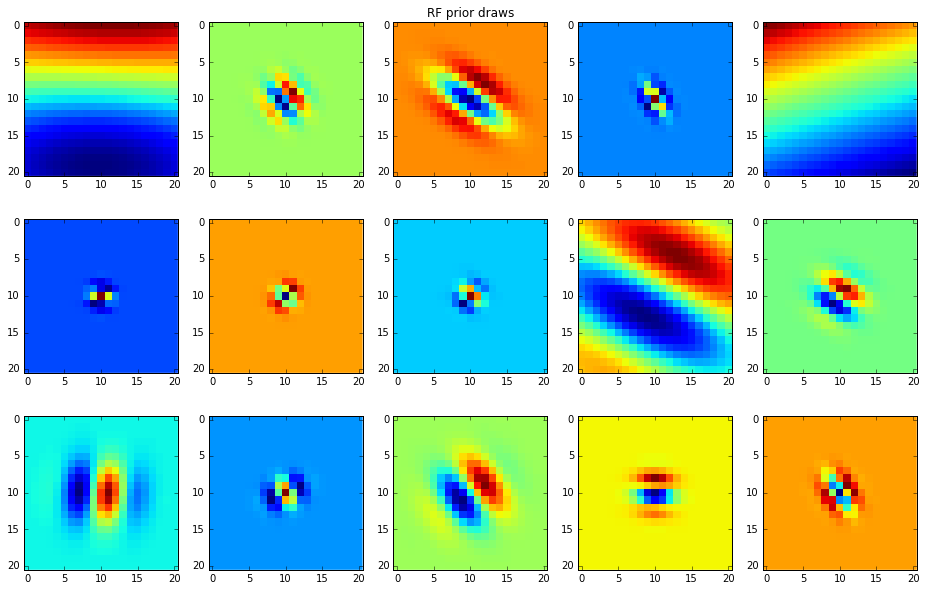

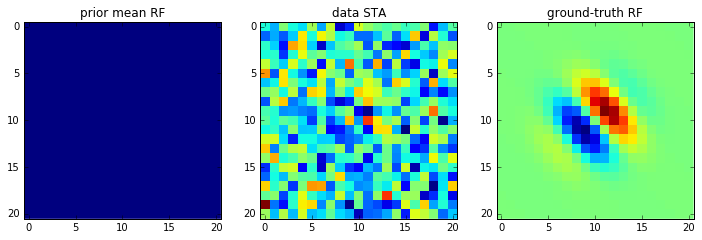

In [2]:

seed = 42

## simulation model

d = 21 # edge length of (quadratic) receptive field
parametrization = 'gabor' # ['full', 'gaussian', 'gabor']
len_kt = 2

params_ls = {'glm': ('bias',),
             'kernel': {'s' : ('gain', 'phase', 'vec_f', 'ratio', 'width'),
                        'l' : [],
                        't' : []}}


#params_ls = {'glm': ('bias',),
#             'kernel': {'s' : ('vec_A', 'vec_f', 'ratio', 'width'),
#                        'l' : [],
#                        't' : ('value',)}}


filter_shape = np.array((d,d,2))
m = maprf(filter_shape=filter_shape, 
          parametrization=parametrization,
          params_ls = params_ls,
          seed=seed, 
          dt = 0.025, 
          duration= 20 )

## prior over simulation parameters
prior = collections.OrderedDict()
if 'bias' in m.params_ls['glm']:
    prior['λo'] = {'mu' : np.array([-0.57]), 'sigma' : np.array([np.sqrt(1.63)]) }
if 'vec_A' in m.params_ls['kernel']['s']:
    prior['vec_A']  = {'mu' : np.zeros(2), 'sigma' : 1.0 * np.ones(2) }
if 'gain' in m.params_ls['kernel']['s']:
    #prior['log_A'] = {'mu' : np.array([1.]), 'sigma' : np.array([1/np.sqrt(.5)])}  
    prior['float_A'] = {'mu' : np.array([0]), 'sigma' : np.array([1.])}  
if 'phase' in m.params_ls['kernel']['s']:
    prior['logit_φ']  = {'mu' : np.array([0]), 'sigma' : np.array([1.78]) }    
if 'vec_f' in m.params_ls['kernel']['s']:
    prior['vec_f']  = {'mu' : np.zeros(2), 'sigma' : 1.0 * np.ones(2) }
if 'ratio' in m.params_ls['kernel']['s']:
    prior['log_γ']  = {'mu' : np.array([-0.098]), 'sigma' : np.array([0.256])}
if 'width' in m.params_ls['kernel']['s']:
    prior['log_b']  = {'mu' : np.array([ 0.955]), 'sigma' : np.array([0.236])}
if 'xo' in m.params_ls['kernel']['l']:
    prior['xo'] = {'mu' : np.array([0.]), 'sigma' : np.array([1/np.sqrt(.5)])}
if 'yo' in m.params_ls['kernel']['l']:
    prior['yo'] = {'mu' : np.array([0.]), 'sigma' : np.array([1/np.sqrt(.5)])}    
L = np.diag(np.concatenate([prior[i]['sigma'] for i in list(prior.keys())]))
if 'value' in m.params_ls['kernel']['t']:
    ax_t = m.dt * np.arange(1,len_kt+1)
    Λ =  np.diag(ax_t / 0.075 * np.exp(1 - ax_t / 0.075))
    D = np.eye(ax_t.shape[0]) - np.eye(ax_t.shape[0], k=-1)
    F = np.dot(D, D.T)
    Σ = np.dot(Λ, np.linalg.inv(F).dot(Λ))
    prior['kt'] = {'mu': np.zeros_like(ax_t), 'sigma': np.linalg.inv(D).dot(Λ)}
    L = np.block([[L, np.zeros((L.shape[0], ax_t.size))], 
                  [np.zeros((ax_t.size, L.shape[1])), prior['kt']['sigma']]])
mu  = np.concatenate([prior[i][ 'mu'  ] for i in prior.keys()])
p = dd.Gaussian(m=mu, S=L.T.dot(L), seed=seed)

#p_gauss = dd.Gaussian(m=mu, S=L.T.dot(L), seed=seed)
#if 'bias' in m.params_ls['glm']:
#    prior['λo'] = {'alpha' : np.array([1.]), 'beta' : np.array([1.]) }
#p_gamma = dd.Gamma(alpha=prior['λo']['alpha'], beta=prior['λo']['beta'])
#p = dd.StackedDistribution(ps=[p_gamma, p_gauss])

## data summary staistics

s = maprfStats(n_summary=d*d)

g = dg.Default(model=m, prior=p, summary=s)

## training data and true parameters, data, statistics

params_dict_true = {'glm': {'binsize': m.dt,
                            'bias': 1.54546216004078},
                    'kernel': {'s': {'angle': 0.7,
                                     'freq': 1.2,
                                     'gain': 0.357703095858336,
                                     'phase': np.pi/2,
                                     'ratio': 1.,
                                     'width': 2.5},
                               'l': {'xo': 0.,
                                     'yo': 0.},
                               't': {'value': np.array([1., 0.])}}}
#                               't': {'tau': 0.015}}}
m.params_dict = params_dict_true
pars_true = m.read_params_buffer()

obs = m.gen_single()
obs_stats = s.calc([obs])

print('firing rate: ', np.sum(obs['data'])/m.duration)
print('total spikes: ', np.sum(obs['data']))


# bunch of example prior draws
plt.figure(figsize=(16,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(m.params_to_rf(p.gen().reshape(-1))[0], interpolation='None')
plt.subplot(3,5,3)
plt.title('RF prior draws')
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(m.params_to_rf(p.mean)[0], interpolation='None')
plt.title('prior mean RF')
plt.subplot(1,3,2)
plt.imshow(obs_stats.reshape(d,d), interpolation='None')
plt.title('data STA')
plt.subplot(1,3,3)
plt.imshow(m.params_to_rf(pars_true)[0], interpolation='None')
plt.title('ground-truth RF')
plt.show()


In [11]:
n_hiddens=(50,50,50)
n_filters=(32,32)

n_train=50#00
epochs=100
minibatch=50
n_rounds=3
n_components=2

from DDELFI import DDELFI

inf = DDELFI(generator=g, obs=obs_stats, prior_norm=False, pilot_samples=None, seed=seed, 
                 n_components=1, n_hiddens=n_hiddens, n_filters=n_filters, n_inputs = (1,d,d))

logs, tds, posteriors, _ = inf.run(n_train=n_train, epochs=epochs, minibatch=minibatch, n_rounds=n_rounds, 
                                   mog_es_rounds=1000, mog_nsteps=-1, mog_lr=0.001,
                           lr_decay=0.99)

posterior = posteriors[-1]

#posterior_raw = inf.predict(obs_stats)
#posterior = (posterior_raw * p) / p_CDELFI

posterior.ndim = posterior.xs[0].ndim

# bunch of example prior draws
plt.figure(figsize=(16,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(m.params_to_rf(p.gen().reshape(-1))[0], interpolation='None')
plt.subplot(3,5,3)
plt.title('RF prior draws')
plt.show()

plt.figure(figsize=(16,5))
plt.subplot(1,5,1)
plt.imshow(m.params_to_rf(p.mean)[0], interpolation='None')
plt.title('prior mean RF')
plt.subplot(1,5,2)
plt.imshow(obs_stats.reshape(d,d), interpolation='None')
plt.title('data STA')
plt.subplot(1,5,3)
plt.imshow(m.params_to_rf(pars_true)[0], interpolation='None')
plt.title('ground-truth RF')
plt.subplot(1,5,4)
plt.imshow(m.params_to_rf(posterior.calc_mean_and_cov()[0])[0], interpolation='None')
plt.title('posterior mean RF')
plt.subplot(1,5,5)
a_max = np.argmax(posterior.a)
plt.imshow(m.params_to_rf(posterior.xs[a_max].m)[0], interpolation='None')
plt.title('posterior mode RF')
plt.show()


# bunch of example posterior draws
plt.figure(figsize=(16,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(m.params_to_rf(posterior.gen().reshape(-1))[0], interpolation='None')
plt.subplot(3,5,3)
plt.title('RF posterior draws')
plt.show()

# all pairwise marginals of fitted posterior
fig, _ = plot_pdf(posterior, pdf2=p, lims=[-3,3], gt=pars_true.reshape(-1), figsize=(16,16), 
                  labels_params=['exp_b', 'vec_A1', 'vec_A2', 'vec_f1', 'vec_f2', 'log ratio', 'log width'])
fig.savefig('res.pdf')

# bunch of example prior draws
plt.figure(figsize=(6,6))
plt.imshow(obs_stats.reshape(d,d), interpolation='None', cmap='gray')
for i in range(100):
    rfm = m.params_to_rf(posterior.gen().reshape(-1))[0]
    plt.contour(rfm, levels=[-0.1, 0.1])
    #print(rfm.min(), rfm.max())
    plt.hold(True)
plt.title('RF posterior draws')
plt.show()


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

loss=[ 33.57803726]: : 3it [00:00, 24.15it/s]

loss=[ nan]: : 998it [00:36, 27.25it/s]        


AssertionError: p must sum to 1

In [ ]:
fig, _ = plot_pdf(posterior, pdf2=p, lims=[-3,3], gt=pars_true.reshape(-1), figsize=(16,16), samples=samples.T, 
                  labels_params=['exp_b', 'vec_A1', 'vec_A2', 'vec_f1', 'vec_f2', 'log ratio', 'log width'])

In [ ]:
print(logs[1][r][1].reshape(n_train,-1).var(axis=0))

r = 1
plt.semilogy(np.sort(1./logs[0][r]['cbkrnl'].A**2)[:100])
plt.show()
plt.semilogy(logs[1][r][1].reshape(n_train,-1).var(axis=0))
plt.show()

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

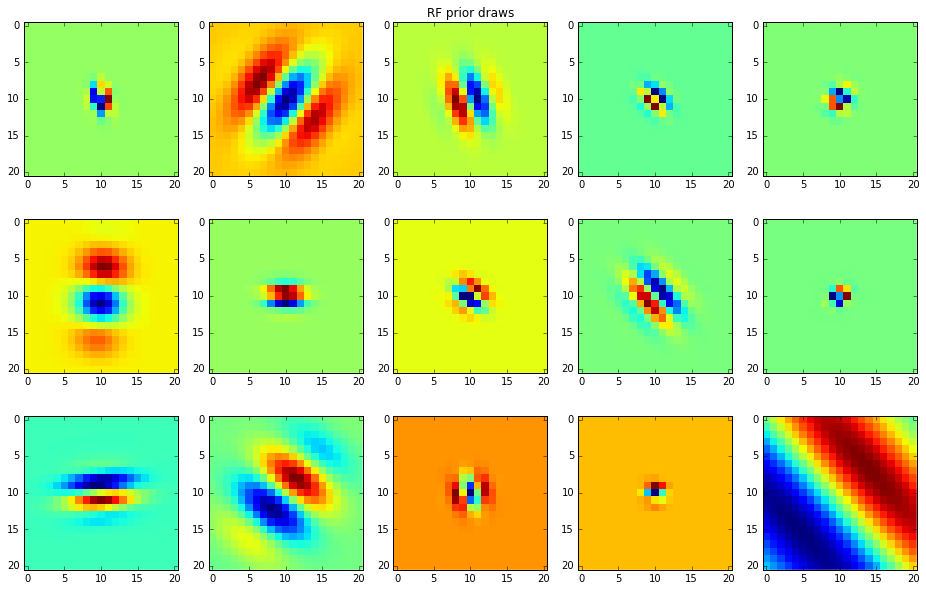

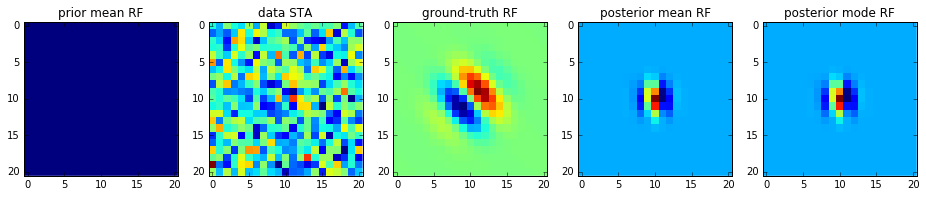

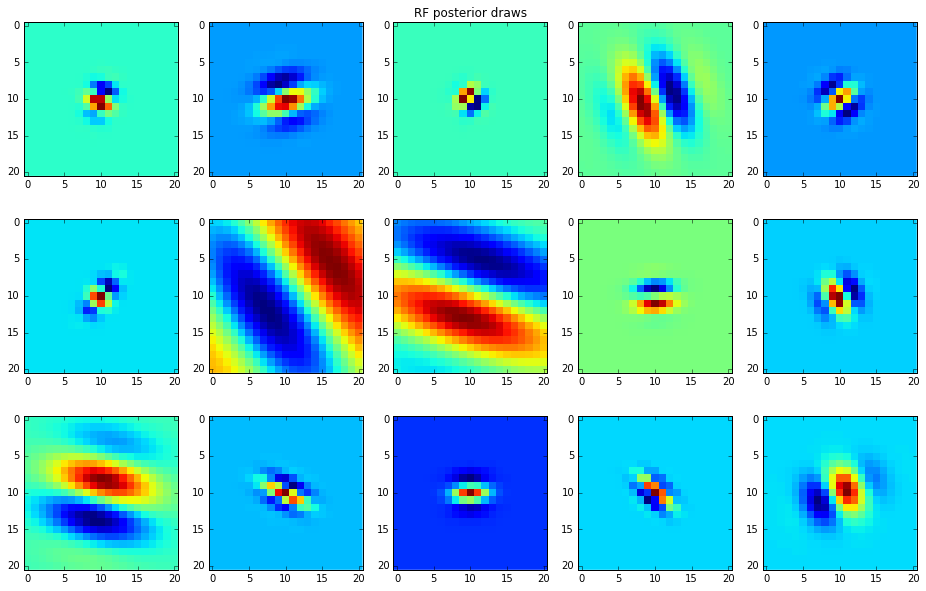

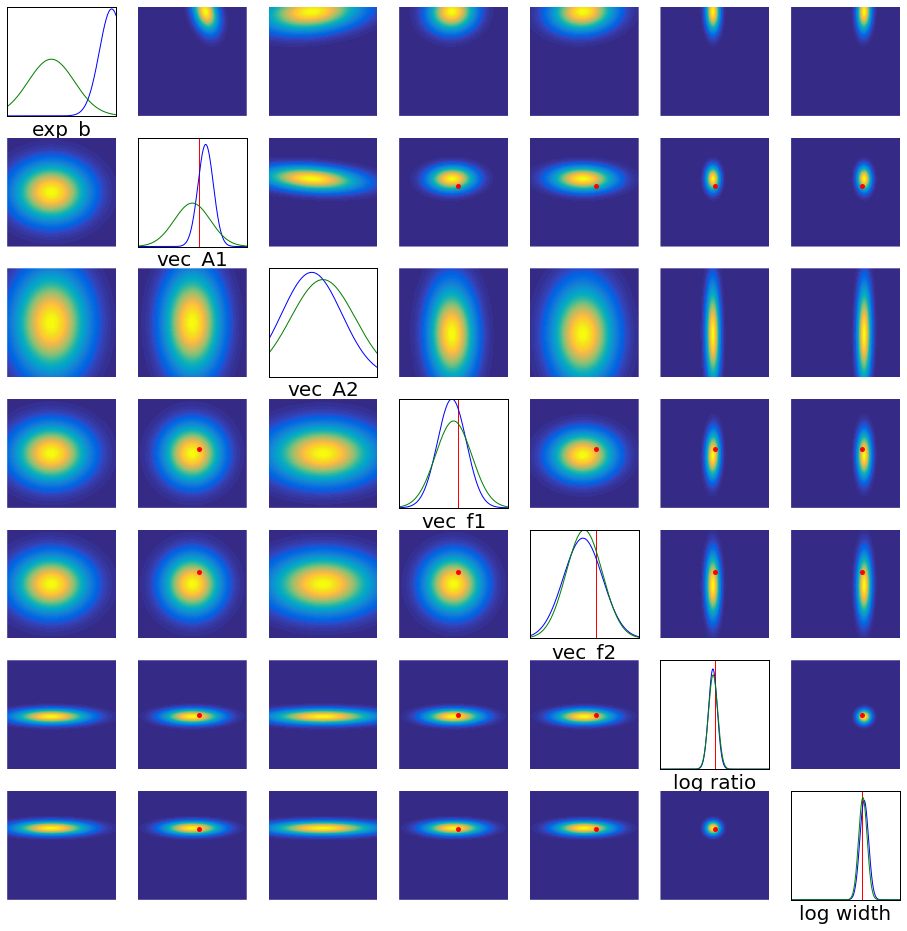

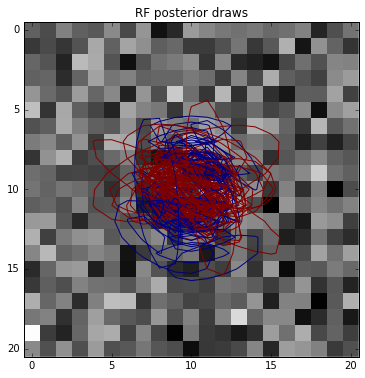

In [7]:
n_hiddens=(50,50,50)
n_filters=(32,32)

n_train=10000
epochs=100
minibatch=50
n_rounds=2
n_components=1

#inf = infer.SNPE(generator=g, obs=obs_stats, prior_norm=True, pilot_samples=100, seed=seed, 
#                 convert_to_T=3,
#                 n_components=n_components, n_hiddens=n_hiddens, n_filters=n_filters, n_inputs = (1,d,d))

inf_CDELFI = infer.CDELFI(generator=g, obs=obs_stats, prior_norm=False, pilot_samples=None, seed=seed,
                 n_components=n_components, n_hiddens=n_hiddens, n_filters=n_filters, n_inputs = (1,d,d))

logs_CDELFI = inf_CDELFI.run(n_train=n_train, epochs=epochs, minibatch=minibatch, n_rounds=n_rounds)

posterior_CDELFI = inf_CDELFI.predict(obs_stats)
posterior_CDELFI.ndim = posterior_CDELFI.xs[0].ndim

# bunch of example prior draws
plt.figure(figsize=(16,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(m.params_to_rf(p.gen().reshape(-1))[0], interpolation='None')
plt.subplot(3,5,3)
plt.title('RF prior draws')
plt.show()

plt.figure(figsize=(16,5))
plt.subplot(1,5,1)
plt.imshow(m.params_to_rf(p.mean)[0], interpolation='None')
plt.title('prior mean RF')
plt.subplot(1,5,2)
plt.imshow(obs_stats.reshape(d,d), interpolation='None')
plt.title('data STA')
plt.subplot(1,5,3)
plt.imshow(m.params_to_rf(pars_true)[0], interpolation='None')
plt.title('ground-truth RF')
plt.subplot(1,5,4)
plt.imshow(m.params_to_rf(posterior_CDELFI.calc_mean_and_cov()[0])[0], interpolation='None')
plt.title('posterior mean RF')
plt.subplot(1,5,5)
a_max = np.argmax(posterior_CDELFI.a)
plt.imshow(m.params_to_rf(posterior_CDELFI.xs[a_max].m)[0], interpolation='None')
plt.title('posterior mode RF')
plt.show()


# bunch of example posterior draws
plt.figure(figsize=(16,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(m.params_to_rf(posterior_CDELFI.gen().reshape(-1))[0], interpolation='None')
plt.subplot(3,5,3)
plt.title('RF posterior draws')
plt.show()

# all pairwise marginals of fitted posterior
fig, _ = plot_pdf(posterior_CDELFI, pdf2=p, lims=[-3,3], gt=pars_true.reshape(-1), figsize=(16,16), 
                  labels_params=['exp_b', 'vec_A1', 'vec_A2', 'vec_f1', 'vec_f2', 'log ratio', 'log width'])
fig.savefig('res.pdf')

# bunch of example prior draws
plt.figure(figsize=(6,6))
plt.imshow(obs_stats.reshape(d,d), interpolation='None', cmap='gray')
for i in range(100):
    rfm = m.params_to_rf(posterior_CDELFI.gen().reshape(-1))[0]
    plt.contour(rfm, levels=[-0.1, 0.1])
    #print(rfm.min(), rfm.max())
    plt.hold(True)
plt.title('RF posterior draws')
plt.show()


In [8]:
#from delfi.distribution.mixture.DefensiveDistribution import DefensiveDistribution as DefD
# defensive sampling
#a = 0.1
#proposal = DefD(a=np.array([a,1.-a]),
#        xs=[p, p_CDELFI])

assert len(posterior_CDELFI.xs)==1
p_CDELFI = logs_CDELFI[2][0].project_to_gaussian() #posterior_CDELFI.project_to_gaussian() #.convert_to_T(dofs=3)
#p_CDELFI.S *= 2

n_hiddens=(50,50,50)
n_filters=(32,32)

n_train=20000
epochs=100
minibatch=200
n_rounds=3
n_components=2


gSNPE = dg.Default(model=m, prior=p, summary=s)

inf = infer.SNPE(generator=gSNPE, obs=obs_stats, prior_norm=False, pilot_samples=None, seed=seed, 
                 n_components=n_components, n_hiddens=n_hiddens, n_filters=n_filters, n_inputs = (1,d,d),
                 convert_to_T=3)
#inf.generator.proposal = proposal #.convert_to_T(dofs=10)
logs = inf.run(n_train=n_train, epochs=epochs, minibatch=minibatch, n_rounds=n_rounds, round_cl=1000,
                 lr_decay=0.99)

posterior = inf.predict(obs_stats)

#posterior_raw = inf.predict(obs_stats)
#posterior = (posterior_raw * p) / p_CDELFI

posterior.ndim = posterior.xs[0].ndim

# bunch of example prior draws
plt.figure(figsize=(16,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(m.params_to_rf(p.gen().reshape(-1))[0], interpolation='None')
plt.subplot(3,5,3)
plt.title('RF prior draws')
plt.show()

plt.figure(figsize=(16,5))
plt.subplot(1,5,1)
plt.imshow(m.params_to_rf(p.mean)[0], interpolation='None')
plt.title('prior mean RF')
plt.subplot(1,5,2)
plt.imshow(obs_stats.reshape(d,d), interpolation='None')
plt.title('data STA')
plt.subplot(1,5,3)
plt.imshow(m.params_to_rf(pars_true)[0], interpolation='None')
plt.title('ground-truth RF')
plt.subplot(1,5,4)
plt.imshow(m.params_to_rf(posterior.calc_mean_and_cov()[0])[0], interpolation='None')
plt.title('posterior mean RF')
plt.subplot(1,5,5)
a_max = np.argmax(posterior.a)
plt.imshow(m.params_to_rf(posterior.xs[a_max].m)[0], interpolation='None')
plt.title('posterior mode RF')
plt.show()

# bunch of example posterior draws
plt.figure(figsize=(16,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(m.params_to_rf(posterior.gen().reshape(-1))[0], interpolation='None')
plt.subplot(3,5,3)
plt.title('RF posterior draws')
plt.show()

# all pairwise marginals of fitted posterior
fig, _ = plot_pdf(posterior, pdf2=p, lims=[-3,3], gt=pars_true.reshape(-1), figsize=(16,16), 
                  labels_params=['exp_b', 'vec_A1', 'vec_A2', 'vec_f1', 'vec_f2', 'log ratio', 'log width'])
fig.savefig('res.pdf')

# bunch of example prior draws
plt.figure(figsize=(6,6))
plt.imshow(obs_stats.reshape(d,d), interpolation='None', cmap='gray')
for i in range(100):
    rfm = m.params_to_rf(posterior.gen().reshape(-1))[0]
    plt.contour(rfm, levels=[-0.1, 0.1])
    #print(rfm.min(), rfm.max())
    plt.hold(True)
plt.title('RF posterior draws')
plt.show()


HBox(children=(IntProgress(value=0, max=20000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000000), HTML(value='')))

KeyboardInterrupt: 

In [ ]:
# number of samples 
print(logs[1][-1][2].shape, n_train)

# effective sample size

print([ np.sum(logs[1][r][2]/n_train)**2 / np.sum((logs[1][r][2]/n_train)**2) for r in range(n_rounds)])

# smallest 99% together have x% of total weight mass
plt.semilogy((np.cumsum(np.sort(logs[1][-1][2]))/np.sum(logs[1][-1][2]))[np.int(0.99*n_train):])
plt.show()

In [ ]:
network_pars_backup = inf.network.params_dict

In [ ]:
tmp=inf.generator.proposal.gen(10000)

tmp = inf.generator.prior.eval(tmp, log=False)/inf.generator.proposal.eval(tmp, log=False)

tmp.sum()**2/np.sum(tmp**2)

In [ ]:
n_train=500000
epochs=50
minibatch=250
n_rounds=2

inf.round = 0

g = dg.Default(model=m, prior=p, summary=s)


inf2 = infer.SNPE(generator=g, obs=obs_stats, prior_norm=False, pilot_samples=None, seed=seed, 
                 n_components=n_components, n_hiddens=n_hiddens, n_filters=n_filters, n_inputs = (1,d,d),
                 convert_to_T=3)
inf2.generator.proposal = posterior.convert_to_T(dofs=3)

log2s = inf2.run(n_train=n_train, epochs=epochs, minibatch=minibatch, n_rounds=n_rounds, round_cl=1000,
                 lr_decay=0.99)

posterior2 = inf2.predict(obs_stats)

#posterior2 = (posterior2 * p) / p_CDELFI

posterior2.ndim = posterior2.xs[0].ndim

fig, _ = plot_pdf(posterior2, pdf2=posterior, lims=[-3,3], gt=pars_true.reshape(-1), figsize=(16,16), 
                  labels_params=['exp_b', 'vec_A1', 'vec_A2', 'vec_f1', 'vec_f2', 'log ratio', 'log width'])

# compare with maprf sampling

In [ ]:
import numpy as np
import numpy.random as nr
import maprf.config as config
import maprf.rfs.v1 as V1
import maprf.invlink as invlink
import maprf.glm as glm 
from maprf.utils import *
from maprf.data import SymbolicData
import time
import maprf.filters as filters
import maprf.kernels as kernels
# from maprf.sampling.slice import EllipticalSliceSampler as ESS

import theano.printing as printing
import theano.tensor as tt

import theano
from theano import In

import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from os import path
from maprf.inference import *

def pyprint(var, filename):
    printing.pydotprint(var, format='pdf', outfile=filename, high_contrast=False, with_ids=True)

cfg = config.load(path.join('config.yaml'))

# The forward part of the model
rf = V1.SimpleLinear_full_kt()
emt = glm.Poisson()
# inputs and outputs
data = [theano.shared(empty(3), 'frames'),
        theano.shared(empty(1, dtype='int64'))]
frames, spikes = data

# fill the grids
rf.grids['s'][0].set_value(m._gen.grid_x)
rf.grids['s'][1].set_value(m._gen.grid_y)
rf.grids['t'][0].set_value(m._gen.axis_t)

# inference model
inference = Inference(rf, emt)
inference.priors = {
    'glm': {         'bias':  {'name':  'gamma',
                               'varname': 'λo',
                               'alpha': 1.0, #prior['λo']['alpha'][0],
                               'beta':  1.0}}, #prior['λo']['beta'][0]}},
    'kernel': {'s': {'freq':  {'name': 'Rayleigh',
                               'varname': 'vec_f',
                               'sigma': prior['vec_f']['sigma'][0]},            
                     'ratio':  {'name': 'normal',
                                'varname': 'log_γ',
                                'sigma': prior['log_γ']['sigma'][0],
                                'mu':    prior['log_γ']['mu'][0]}, 
                     'width':  {'name': 'normal',
                                'varname': 'log_b',
                                'sigma': prior['log_b']['sigma'][0],
                                'mu':    prior['log_b']['mu'][0]}}}}        
if 'vec_A' in prior.keys():
    inference.priors['kernel']['s']['phase'] =   {'name': 'Rayleigh',
                                                  'varname': 'vec_A',
                                                  'sigma': prior['vec_A']['sigma'][0]}            
elif 'log_A' in prior.keys() and 'logit_φ' in prior.keys():
    inference.priors['kernel']['s']['gain'] =  {'name': 'lognormal',
                                                  'varname': 'log_A',
                                                  'mu': prior['log_A']['mu'][0],
                                                  'sigma': prior['log_A']['sigma'][0]}            
    inference.priors['kernel']['s']['phase'] =  {'name': 'logitnormal',
                                                  'varname': 'logit_φ',
                                                  'mu': prior['logit_φ']['mu'][0],
                                                  'sigma': prior['logit_φ']['sigma'][0]}            
elif 'float_A' in prior.keys() and 'logit_φ' in prior.keys():
    inference.priors['kernel']['s']['gain'] =  {'name': 'normal',
                                                  'varname': 'float_A',
                                                  'mu': prior['float_A']['mu'][0],
                                                  'sigma': prior['float_A']['sigma'][0]}            
    inference.priors['kernel']['s']['phase'] =  {'name': 'logitnormal',
                                                  'varname': 'logit_φ',
                                                  'mu': prior['logit_φ']['mu'][0],
                                                  'sigma': prior['logit_φ']['sigma'][0]}      
else:
    raise NotImplemented()


if 'kt' in prior.keys():
    inference.priors['kernel']['t'] = prior['kt']


inference.add_sampler(GaborSampler(fix_position=True, parametrization='logit_φ'))
print(inference.samplers[0].params)

#inference.add_sampler(KernelSampler())
kt = tt.vector('kt')
inference.rf.filter.kernel['t'] = kt / tt.sqrt(tt.dot(kt, kt))
#inference.add_update(kt, kt)
inference.add_inputs(kt)

print('inputs: ', inference.inputs)
print('priors: ', inference.priors)

inference.build(data)
inference.compile()


inference.loglik['xo'] = 0.
inference.loglik['yo'] = 0.
#inference.loglik['logit_φ'] = 0.0  # np.array([2.0, 0.0])
ks = params_dict_true['kernel']['s']
vec_f = m.pol2cart(np.atleast_2d([ks['freq'], ks['angle']])).reshape(-1)
log_γ = np.log(ks['ratio'])
log_b = np.log(ks['width'])
inference.loglik['vec_f'] = vec_f  # np.zeros(2)  # 0.3 * np.array([np.cos(0.7), np.sin(0.7)])
inference.loglik['log_γ'] = log_γ  # 0.
inference.loglik['log_b'] = log_b # np.log(2.5)
inference.loglik['kt'] =    params_dict_true['kernel']['t']['value'].copy()  # np.array([0.5, 0.0])

if 'vec_A' in prior.keys():
    vec_A = m.pol2cart(np.atleast_2d([ks['gain'], ks['phase']])).reshape(-1)
    inference.loglik['vec_A'] = vec_A  # np.zeros(2)  # 0.3 * np.array([np.cos(0.7), np.sin(0.7)])
elif 'log_A' in prior.keys() and 'logit_φ' in prior.keys():
    log_A, logit_φ = ks['gain'], ks['phase']
    inference.loglik['log_A'] = log_A  # np.zeros(2)  # 0.3 * np.array([np.cos(0.7), np.sin(0.7)])
    inference.loglik['logit_φ'] = logit_φ  # np.zeros(2)  # 0.3 * np.array([np.cos(0.7), np.sin(0.7)])
elif 'float_A' in prior.keys() and 'logit_φ' in prior.keys():
    float_A, logit_φ = ks['gain'], ks['phase']
    inference.loglik['float_A'] = float_A  # np.zeros(2)  # 0.3 * np.array([np.cos(0.7), np.sin(0.7)])
    inference.loglik['logit_φ'] = logit_φ  # np.zeros(2)  # 0.3 * np.array([np.cos(0.7), np.sin(0.7)])



frames.set_value(obs['I'][:,:].reshape(-1,d,d))
spikes.set_value(obs['data'][:])

#frames.set_value(0*obs['I'][:1,:].reshape(-1,d,d))
#spikes.set_value(0*obs['data'][:1])


#frames.set_value(np.zeros((1,d,d)))
#spikes.set_value(np.zeros(1,dtype=np.int))

plt.plot(spikes.get_value())

print(np.sum(obs['data']))

In [ ]:

import datetime

T, L = inference.sample(100000)
T = {k.name: t for k, t in T.items()}

x = T['xo']
y = T['yo']

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(x[500:])

plt.subplot(122)
plt.hist(x[500:], alpha=0.5, normed=True)
plt.show()

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(x[500:], y[500:], '.k', alpha=0.1)
plt.show()


In [ ]:
inference.sample_biases(data, T, cfg['sim']['dt'])

plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(T['bias'])
print('mean: ' + str(T['bias'].mean()) + ', var: ' + str(T['bias'].var()))
plt.subplot(2,1,2)
plt.plot(T['λo'])
print('mean: ' + str(T['λo'].mean()) + ', var: ' + str(T['λo'].var()))
plt.show()


In [ ]:

for t in np.sort(np.random.choice(T['vec_f'].shape[0], 100, replace=False)):
    params_dict = {'kernel' : {'s' : {}}, 'glm': {}}
    params_dict['glm']['bias'] = T['bias'][t]
    params_dict['kernel']['s']['phase'] = T['phase'][t]
    params_dict['kernel']['s']['angle'] = T['angle'][t] 
    params_dict['kernel']['s']['freq']  = T['freq'][t]
    params_dict['kernel']['s']['ratio'] = T['ratio'][t]
    params_dict['kernel']['s']['width'] = T['width'][t]
    params_dict['kernel']['s']['gain'] = T['gain'][t]

    ks = m._eval_ks(bias=-0.5, 
                             angle=params_dict['kernel']['s']['angle'],
                             freq=params_dict['kernel']['s']['freq'],
                             gain=params_dict['kernel']['s']['gain'],
                             phase=params_dict['kernel']['s']['phase'],
                             ratio=params_dict['kernel']['s']['ratio'],
                             width=params_dict['kernel']['s']['width'])

    plt.imshow(ks.reshape(d,d), interpolation='None')
    plt.title('t =' + str(t))
    plt.show()

    print('loc:' , [T['xo'][t], T['yo'][t]])

In [ ]:
x=T['ratio'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('ratio')
plt.show()
print('mean:', T['ratio'].mean())
print('var:', T['ratio'].var())

x=T['log_γ'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('log ratio')
plt.show()
print('mean:', T['log_γ'].mean())
print('var:', T['log_γ'].var())

x=T['width'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('width')
plt.show()
print('mean:', T['width'].mean())
print('var:', T['width'].var())

x=T['log_b'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('log width')
plt.show()
print('mean:', T['log_b'].mean())
print('var:', T['log_b'].var())


x=T['angle'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('angle')
plt.show()
print('mean:', T['angle'].mean())
print('var:', T['angle'].var())

x=T['freq'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('freq')
plt.show()
print('mean:', T['freq'].mean())
print('var:', T['freq'].var())

x=T['vec_f'][50:,0]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('vec_f[0]')
plt.show()
print('mean:', T['vec_f'][:,0].mean())
print('var:',  T['vec_f'][:,0].var())

x=T['vec_f'][50:,1]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('vec_f[1]')
plt.show()
print('mean:', T['vec_f'][:,1].mean())
print('var:',  T['vec_f'][:,1].var())


x=T['phase'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('phase')
plt.show()
print('mean:', T['phase'].mean())
print('var:', T['phase'].var())

if 'logit_φ' in T.keys():
    x=T['logit_φ'][50:]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('logit phase')
    plt.show()
    print('mean:', T['logit_φ'].mean())
    print('var:', T['logit_φ'].var())

if 'log_A' in T.keys():
    x=T['log_A'][50:]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('log_A')
    plt.show()
    print('mean:', T['log_A'][:].mean())
    print('var:',  T['log_A'][:].var())

if 'vec_A' in T.keys():
    x=T['vec_A'][50:,0]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('vec_A[0]')
    plt.show()
    print('mean:', T['vec_A'][:,0].mean())
    print('var:',  T['vec_A'][:,0].var())    
    x=T['vec_A'][50:,1]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('vec_A[1]')
    plt.show()
    print('mean:', T['vec_A'][:,1].mean())
    print('var:',  T['vec_A'][:,1].var())
    
if 'bias' in T.keys():
    x=T['bias'][50:]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('bias')
    plt.show()
    print('mean:', T['bias'].mean())
    print('var:', T['bias'].var())

if 'λo' in T.keys():
    x=T['λo'][50:]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('exp bias')
    plt.show()
    print('mean:', T['λo'].mean())
    print('var:', T['λo'].var())


In [ ]:
try: 
    np.savez('posterior_samples', {'T' : T})
except:
    pass

In [ ]:
T = np.load('posterior_samples.npz')['arr_0'].tolist()['T']


In [ ]:
#T['b'] = np.zeros((T['vec_f'].shape[0], 1))
if 'vec_A' in prior.keys(): 
    samples = np.hstack([np.atleast_2d(T[key].T).T for key in ['bias','vec_A','vec_f','log_γ','log_b']])
elif 'log_A' in prior.keys() and 'logit_φ' in prior.keys(): 
    samples = np.hstack([np.atleast_2d(T[key].T).T for key in ['bias','log_A', 'logit_φ', 'vec_f','log_γ','log_b']])
elif 'float_A' in prior.keys() and 'logit_φ' in prior.keys(): 
    samples = np.hstack([np.atleast_2d(T[key].T).T for key in ['bias','float_A', 'logit_φ', 'vec_f','log_γ','log_b']])


S=np.cov(samples.T)
posterior_sampled = dd.Gaussian(m=samples.mean(axis=0), S=S)

# results gallery

In [ ]:
# student-t proposals (seed #1)
plot_pdf((logs[2][1]*p)/p_CDELFI, pdf2=(logs[2][0]*p)/p_CDELFI, lims=[-5,5], figsize=(16,16), samples=samples.T);


In [ ]:

# all pairwise marginals of fitted posterior
plot_pdf(posterior, pdf2=posterior_CDELFI, lims=[-5,5], figsize=(16,16), samples=samples.T);


In [ ]:
import delfi.distribution as dd
from delfi.neuralnet.NeuralNet import NeuralNet

def save_mog(mog, filename=None):
    """Save mixture of Gaussians (avoiding pickle)
    
    Saves the key arrays of a Mixture of Gaussians. 
    
    Parameters
    ----------
    mog : (Mixture of) Gaussian object
        mixture 
    filename : string
        desired save file location. If None, does not
        save and returns dictionary with arrays instead.
    
    """        
    assert isinstance(posterior, (dd.MoG, dd.Gaussian))
    
    if isinstance(mog, dd.MoG):
        
        save_dict = {'a'  : mog.a,
                     'ms' : [x.m for x in mog.xs],
                     'Ss' : [x.S for x in mog.xs],
                     'seed' : mog.seed}
        
    elif isinstance(mog, dd.Gaussian):
        
        save_dict = {'a'  : np.ones(1),
                     'ms' : [mog.m], 
                     'Ss' : [mog.S],
                     'seed' : mog.seed}
        
            
    if not filename is None: 
        np.save(filename, save_dict)
    else:
        return save_dict
    
def load_mog(filename):
    """Load mixture of Gaussians (avoiding pickle)
    
    Loads key arrays of a Mixture of Gaussians and returns the 
    corresponding object. 
    
    Parameters
    ----------
    filename : string
        save file location (with or without file extension)
    
    """
    if not filename[-4:]=='.npy':
        filename += '.npy'
    
    sd = np.load(filename)[()]
    
    mog = dd.MoG(a=sd['a'], ms=sd['ms'], Ss=sd['Ss'], seed=sd['seed'])
    
    return mog

def save_res(p, posterior, network, filename, proposal=None):

    prior = save_mog(p)
    posterior = save_mog(posterior)
    
    net_pars = network.params_dict
    net_spec = network.spec_dict
    
    if proposal is None:
        np.savez(filename, 
                 p=prior,
                 posterior=posterior,
                 net_pars=net_pars,
                 net_spec=net_spec)
    else:
        proposal=save_mog(proposal)
        np.savez(filename, 
                 p=prior,
                 proposal=proposal,
                 posterior=posterior,
                 net_pars=net_pars,
                 net_spec=net_spec)
        
    
def load_res(filename):
    
    load_file = np.load(filename)

    ld = load_file['p'][()]
    p = dd.MoG(a=ld['a'], ms=ld['ms'], Ss=ld['Ss'], seed=ld['seed'])
    
    if 'proposal' in load_file.keys():
        ld = load_file['proposal'][()]
        proposal = dd.MoG(a=ld['a'], ms=ld['ms'], Ss=ld['Ss'], seed=ld['seed'])
    else:
        proposal = None

    ld = load_file['posterior'][()]
    posterior = dd.MoG(a=ld['a'], ms=ld['ms'], Ss=ld['Ss'], seed=ld['seed'])
    
    ns = load_file['net_spec'][()]
    network = NeuralNet(n_inputs=ns['n_inputs'],
                            n_outputs=ns['n_outputs'],
                            n_components=ns['n_components'],
                            n_filters=ns['n_filters'],
                            n_hiddens=ns['n_hiddens'],
                            n_rnn=ns['n_rnn'],
                            seed=ns['seed'],
                            svi=ns['svi'])
    network.params_dict = load_file['net_pars'][()]
    
    return p, posterior, network, proposal

In [ ]:
save_res(p, posterior, inf.network, filename='maprf_2modes_proofOfConcept_fit', proposal=p_CDELFI)

In [ ]:
p_, posterior_, network_, proposal_ = load_res('maprf_2modes_proofOfConcept_fit.npz')

In [ ]:
inf3 = infer.SNPE(generator=gSNPE, obs=obs_stats, prior_norm=False, pilot_samples=None, seed=seed, 
                 n_components=n_components, n_hiddens=n_hiddens, n_filters=n_filters, n_inputs = (1,d,d),
                 convert_to_T=3)
inf3.network = network_
inf3.predict(obs_stats)
